<a href="https://colab.research.google.com/github/sutummala/periCellNet/blob/main/periCellNet_Contrastive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
%cd /content
!mkdir drive
%cd drive
!mkdir MyDrive
%cd ..
%cd ..
!google-drive-ocamlfuse /content/drive/MyDrive

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 155222 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.27-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.27-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.27-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [ ]:
import os
import tensorflow as tf
#import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers
#import tensorflow_addons as tfa
from sklearn.model_selection import StratifiedKFold, cross_val_score
import sklearn
import nibabel as nib
import numpy as np
import random
import matplotlib.pyplot as plt
from skimage.transform import resize
from IPython.display import Image, display
import matplotlib.cm as cm

In [ ]:
# Data paths for loading individual cells 

basophil = np.load('/content/drive/MyDrive/Datasets/PBC_dataset_normal_DIB/basophil.npy')
print(f'basophil tensor shape is {basophil.shape}')
basophil_labels = np.zeros(len(basophil))

eosinophil = np.load('/content/drive/MyDrive/Datasets/PBC_dataset_normal_DIB/eosinophil.npy')
print(f'eosinophil tensor shape is {eosinophil.shape}')
eosinophil_labels = np.ones(len(eosinophil))

ig = np.load('/content/drive/MyDrive/Datasets/PBC_dataset_normal_DIB/ig.npy')
print(f'immature grannulocyte tensor shape is {ig.shape}')
ig_labels = 2 * np.ones(len(ig))

erythroblast = np.load('/content/drive/MyDrive/Datasets/PBC_dataset_normal_DIB/erythroblast.npy')
print(f'erythroblast tensor shape is {erythroblast.shape}')
erythroblast_labels = 3 * np.ones(len(erythroblast))

lymphocyte = np.load('/content/drive/MyDrive/Datasets/PBC_dataset_normal_DIB/lymphocyte.npy')
print(f'lymphocyte tensor shape is {lymphocyte.shape}')
lymphocyte_labels = 4 * np.ones(len(lymphocyte))

monocyte = np.load('/content/drive/MyDrive/Datasets/PBC_dataset_normal_DIB/monocyte.npy')
print(f'monocyte tensor shape is {monocyte.shape}')
monocyte_labels = 5 * np.ones(len(monocyte))

platelet = np.load('/content/drive/MyDrive/Datasets/PBC_dataset_normal_DIB/platelet.npy')
print(f'platelet tensor shape is {platelet.shape}')
platelet_labels = 6 * np.ones(len(platelet))

neutrophil = np.load('/content/drive/MyDrive/Datasets/PBC_dataset_normal_DIB/neutrophil.npy')
print(f'neutrophil tensor shape is {neutrophil.shape}')
neutrophil_labels =  7 * np.ones(len(neutrophil))

basophil tensor shape is (1218, 358, 358, 3)
eosinophil tensor shape is (3117, 358, 358, 3)
immature grannulocyte tensor shape is (2895, 358, 358, 3)
erythroblast tensor shape is (1551, 358, 358, 3)
lymphocyte tensor shape is (1214, 358, 358, 3)
monocyte tensor shape is (1420, 358, 358, 3)
platelet tensor shape is (2348, 358, 358, 3)
neutrophil tensor shape is (3329, 358, 358, 3)


In [ ]:
def find_compare_to(l, i, j, index, no_of_pairs):
  
  # finding indices
  if True:
    compare_to = i
    while compare_to == i: # Making sure it's not comparing to itself
      if l == 0: # Label 0
        if (j % 2 != 0):
          compare_to = random.randint(0, index-1)
        else:
          compare_to = random.randint(index, 8*index-1)
      elif l == 1:
        if (j % 2 != 0):
          compare_to = random.randint(index, 2*index-1)
        elif j <= int(0.2*no_of_pairs) and (j % 2 == 0):
          compare_to = random.randint(0, index-1)
        else:
          compare_to = random.randint(2*index, 8*index-1)
      elif l == 2:
        if (j % 2 != 0):
          compare_to = random.randint(2*index, 3*index-1)
        elif j <= int(0.3*no_of_pairs) and (j % 2 == 0):
          compare_to = random.randint(0, 2*index-1)
        else:
          compare_to = random.randint(3*index, 8*index-1)
      elif l == 3:
        if (j % 2 != 0):
          compare_to = random.randint(3*index, 4*index-1)
        elif j <= int(0.4*no_of_pairs) and (j % 2 == 0):
          compare_to = random.randint(0, 3*index-1)
        else:
          compare_to = random.randint(4*index, 8*index-1)
      elif l == 4:
        if (j % 2 != 0):
          compare_to = random.randint(4*index, 5*index-1)
        elif j <= int(0.5*no_of_pairs) and (j % 2 == 0):
          compare_to = random.randint(0, 4*index-1)
        else:
          compare_to = random.randint(5*index, 8*index-1)
      elif l == 5:
        if (j % 2 != 0):
          compare_to = random.randint(5*index, 6*index-1)
        elif j <= int(0.6*no_of_pairs) and (j % 2 == 0):
          compare_to = random.randint(0, 5*index-1)
        else:
          compare_to = random.randint(6*index, 8*index-1)
      elif l == 6:
        if (j % 2 != 0):
          compare_to = random.randint(6*index, 7*index-1)
        elif j <= int(0.7*no_of_pairs) and (j % 2 == 0):
          compare_to = random.randint(0, 6*index-1)
        else:
          compare_to = random.randint(7*index, 8*index-1)
      elif l == 7:
        if (j % 2 != 0):
          compare_to = random.randint(7*index, 8*index-1)
        else:
          compare_to = random.randint(0, 7*index-1)
  
  return compare_to

In [ ]:
def generate_pairs(X, y, index, no_of_pairs):
    
    image_list = np.split(X, X.shape[0])
    label_list = np.split(y, len(y))
    
    left_input = []
    right_input = []
    targets = []
    
    no_of_labels = np.unique(y) # Number of classes

    for l in range(len(no_of_labels)):
      if l == 0:
        print('doing for label 0')
        for i in range(0, index):
          for j in range(no_of_pairs):
            compare_to = find_compare_to(l, i, j, index, no_of_pairs)
            left_input.append(image_list[i])
            right_input.append(image_list[compare_to])
            if label_list[i] == label_list[compare_to]: # They are same
                targets.append(1.)
            else:# Not same
                targets.append(0.)
        print(f'targets {len(targets)}')
      if l == 1:
        print('doing for label 1')
        for i in range(index, 2*index):
          for j in range(no_of_pairs):
            compare_to = find_compare_to(l, i, j, index, no_of_pairs)
            left_input.append(image_list[i])
            right_input.append(image_list[compare_to])
            if label_list[i] == label_list[compare_to]: # They are same
                targets.append(1.)
            else:# Not same
                targets.append(0.)
        print(f'targets {len(targets)}')
      if l == 2:
        print('doing for label 2')
        for i in range(2*index, 3*index):
          for j in range(no_of_pairs):
            compare_to = find_compare_to(l, i, j, index, no_of_pairs)
            left_input.append(image_list[i])
            right_input.append(image_list[compare_to])
            if label_list[i] == label_list[compare_to]: # They are same
                targets.append(1.)
            else:# Not same
                targets.append(0.)
        print(f'targets {len(targets)}')
      if l == 3:
        print('doing for label 3')
        for i in range(3*index, 4*index):
          for j in range(no_of_pairs):
            compare_to = find_compare_to(l, i, j, index, no_of_pairs)
            left_input.append(image_list[i])
            right_input.append(image_list[compare_to])
            if label_list[i] == label_list[compare_to]: # They are same
                targets.append(1.)
            else:# Not same
                targets.append(0.)
        print(f'targets {len(targets)}')
      if l == 4:
        print('doing for label 4')
        for i in range(4*index, 5*index):
          for j in range(no_of_pairs):
            compare_to = find_compare_to(l, i, j, index, no_of_pairs)
            left_input.append(image_list[i])
            right_input.append(image_list[compare_to])
            if label_list[i] == label_list[compare_to]: # They are same
                targets.append(1.)
            else:# Not same
                targets.append(0.)
        print(f'targets {len(targets)}')
      if l == 5:
        print('doing for label 5')
        for i in range(5*index, 6*index):
          for j in range(no_of_pairs):
            compare_to = find_compare_to(l, i, j, index, no_of_pairs)
            left_input.append(image_list[i])
            right_input.append(image_list[compare_to])
            if label_list[i] == label_list[compare_to]: # They are same
                targets.append(1.)
            else:# Not same
                targets.append(0.)
        print(f'targets {len(targets)}')
      if l == 6:
        print('doing for label 6')
        for i in range(6*index, 7*index):
          for j in range(no_of_pairs):
            compare_to = find_compare_to(l, i, j, index, no_of_pairs)
            left_input.append(image_list[i])
            right_input.append(image_list[compare_to])
            if label_list[i] == label_list[compare_to]: # They are same
                targets.append(1.)
            else:# Not same
                targets.append(0.)
        print(f'targets {len(targets)}')
      if l == 7:
        print('doing for label 7')
        for i in range(7*index, 8*index):
          for j in range(no_of_pairs):
            compare_to = find_compare_to(l, i, j, index, no_of_pairs)
            left_input.append(image_list[i])
            right_input.append(image_list[compare_to])
            if label_list[i] == label_list[compare_to]: # They are same
                targets.append(1.)
            else:# Not same
                targets.append(0.)
        print(f'targets {len(targets)}')

    left_input = np.squeeze(np.array(left_input))
    right_input = np.squeeze(np.array(right_input))
    targets = np.squeeze(np.array(targets))
    
    return left_input, right_input, targets

In [ ]:
#y_cor = np.ones(np.shape(lymphocyte)[0])

#y_incor = np.zeros(np.shape(monocyte)[0])

#y_true = np.concatenate((y_cor, y_incor))

#X = np.concatenate((lymphocyte, monocyte))

index = 50

X = np.concatenate((basophil[index:2*index, :, :, :], eosinophil[index:2*index, :, :, :], 
                    ig[index:2*index, :, :, :], erythroblast[index:2*index, :, :, :], lymphocyte[index:2*index, :, :, :], 
                    monocyte[index:2*index, :, :, :], platelet[index:2*index, :, :, :], neutrophil[index:2*index, :, :, :]))
y = np.concatenate((basophil_labels[index:2*index], eosinophil_labels[index:2*index], 
                    ig_labels[index:2*index], erythroblast_labels[index:2*index], lymphocyte_labels[index:2*index], 
                    monocyte_labels[index:2*index], platelet_labels[index:2*index], neutrophil_labels[index:2*index]))

#X = tf.image.resize(X, [380, 380])

print(X.shape)
print(y.shape)
print(len(np.unique(y)))

left_input, right_input, targets = generate_pairs(X, y, index, no_of_pairs = 10)

#targets = np.load('/content/drive/My Drive/Autism_CNN/autism_labels.npy')

targets = 1-targets # 1 for different pair and 0 for same pair 

print(f'total size of the data is {len(targets)}')

(400, 358, 358, 3)
(400,)
8
doing for label 0
targets 500
doing for label 1
targets 1000
doing for label 2
targets 1500
doing for label 3
targets 2000
doing for label 4
targets 2500
doing for label 5
targets 3000
doing for label 6
targets 3500
doing for label 7
targets 4000
total size of the data is 4000


In [ ]:
left_input = left_input[:, 30:330, 30:330, :]
right_input = right_input[:, 30:330, 30:330, :]

left_input.shape

(4000, 300, 300, 3)

In [ ]:
np.save('/content/drive/MyDrive/Datasets/PBC_dataset_normal_DIB/siamese_left_input', left_input)
np.save('/content/drive/MyDrive/Datasets/PBC_dataset_normal_DIB/siamese_right_input', right_input)
np.save('/content/drive/MyDrive/Datasets/PBC_dataset_normal_DIB/siamese_labels', targets)

In [ ]:
left_input = np.load('/content/drive/MyDrive/Datasets/PBC_dataset_normal_DIB/siamese_right_input.npy')
right_input = np.load('/content/drive/MyDrive/Datasets/PBC_dataset_normal_DIB/siamese_left_input.npy')
targets = np.load('/content/drive/MyDrive/Datasets/PBC_dataset_normal_DIB/siamese_labels.npy')

print(left_input.shape)
print(right_input.shape)
print(np.unique(targets))

(4000, 300, 300, 3)
(4000, 300, 300, 3)
[0. 1.]


In [ ]:
left_input = tf.image.resize(left_input, [380, 380])

In [ ]:
right_input = tf.image.resize(right_input, [380, 380])

In [ ]:
cv_index = int(0.8 * len(targets)) 

left_input_cv = left_input[:cv_index]
right_input_cv = right_input[:cv_index]
targets_cv = targets[:cv_index]

print(f'shape of left/right input for CV is {left_input_cv.shape}')
print(f'input size for cross-validation is {len(targets_cv)}')
print(f'no.of positive pairs in CV are {np.shape(np.nonzero(targets_cv))[1]}')

left_input_test = left_input[cv_index:]
right_input_test = right_input[cv_index:]
targets_test = targets[cv_index:]

print(f'shape of left/right input for testing is {left_input_test.shape}')
print(f'input size for testing is {len(targets_test)}')
print(f'no.of positive pairs in test are {np.shape(np.nonzero(targets_test))[1]}')

In [ ]:
def contrastive_loss(y_true, y_pred):
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean((1-y_true) * square_pred + y_true * margin_square)

In [ ]:
def SiameseNetwork(input_shape):
    
    moving_input = tf.keras.Input(input_shape)
    ref_input = tf.keras.Input(input_shape)
    
    # base_model using EfficientNetB3

    inp = tf.keras.layers.Input(shape=input_shape)
    #inp = tf.keras.applications.resnet50.preprocess_input(inp)
    base_model = tf.keras.applications.EfficientNetB4(include_top=False, weights='imagenet', input_tensor=inp,
                                          input_shape=input_shape)

    index = int(0.9 * len(base_model.layers))
    
    for layer in base_model.layers[:index]:
      layer.trainable = False

    last_conv_layer = base_model.get_layer('top_activation')
    #last_conv_layer = base_model.get_layer('conv5_block3_out')

    x =  tf.keras.layers.GlobalAveragePooling2D()(last_conv_layer.output)
    #x = tf.keras.layers.BatchNormalization()(x)
    #x = tf.keras.layers.Dense(256, activation = 'relu', name = 'dense_layer')(x)

    model = tf.keras.models.Model(inputs = inp, outputs = x)
    
    # Siamese model starts here

    encoded_moving  = model(moving_input)
    encoded_ref = model(ref_input)

    L1_layer = tf.keras.layers.Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]), name = 'lambda_layer')
    #L2_layer = tf.keras.layers.Lambda(lambda tensors:K.l2_normalize((tensors[0] - tensors[1]), axis = 1))

    L1_distance = L1_layer([encoded_moving, encoded_ref]) # L1-norm
    #L2_distance = L2_layer([encoded_moving, encoded_ref]) # L2-norm or Euclidean Norm
    #L2_distance = tf.keras.layers.Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([encoded_moving, encoded_ref])

    prediction = tf.keras.layers.Dense(1, activation='sigmoid')(L1_distance)
    siamesenet = tf.keras.Model(inputs = [moving_input, ref_input], outputs = prediction, name = 'siamese_3dmodel')
    
    return siamesenet, model

In [ ]:
img_shape = (380, 380, 3)

In [ ]:
tf.keras.backend.clear_session()

resolver = tf.distribute.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)

# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

strategy = tf.distribute.experimental.TPUStrategy(resolver)

In [ ]:
#with strategy.scope():
siamese_model, base_model = SiameseNetwork(img_shape)
base_model.summary()
siamese_model.summary()
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
siamese_model.compile(optimizer = tf.keras.optimizers.Adadelta(learning_rate = 1.0), loss = contrastive_loss, metrics = 'accuracy')
    
history_fine = siamese_model.fit([left_input, right_input], targets, batch_size = 32, epochs = 15)

71696384/71686520 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 380, 380, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 380, 380, 3)  0           ['input_3[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 380, 380, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D

In [ ]:
predicton_prob = siamese_model.predict([left_input_test, right_input_test])

print(np.transpose(predicton_prob))

predicton_prob[predicton_prob > 0.5] = 1
predicton_prob[predicton_prob <= 0.5] = 0

tn, fp, fn, tp = sklearn.metrics.confusion_matrix(targets_test, predicton_prob).ravel()

print(f'test Accuracy: {sklearn.metrics.accuracy_score(targets_test, predicton_prob)}')
print(f'test ROC (AUC): {sklearn.metrics.roc_auc_score(targets_test, predicton_prob)}')
print(f'test Sensitivity (Recall): {sklearn.metrics.recall_score(targets_test, predicton_prob)}')
print(f'test Precision: {sklearn.metrics.precision_score(targets_test, predicton_prob)}')
print(f'test F1-score: {sklearn.metrics.f1_score(targets_test, predicton_prob)}')
print(f'test Mathews Correlation Coefficient: {sklearn.metrics.matthews_corrcoef(targets_test, predicton_prob)}')
print(f'test Specificity: {tn/(tn+fp)}')
print(targets_test)

In [ ]:
def save_and_display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.5):
    
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)
    #heatmap = np.uint8(heatmap/50)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    jet_heatmap_path = 'heatmap.jpg'

    # Save the superimposed image
    superimposed_img.save(cam_path)

    jet_heatmap1 = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap1.save(jet_heatmap_path)

    # Display Grad CAM
    display(Image(cam_path))
    #display(Image(jet_heatmap_path))

In [ ]:
# Save Model
siamese_model.save('/content/drive/My Drive/periCellNet/siamese_pericell_model_adadelta_1.0_32_15_4000_B4')

In [ ]:
siamese_model = tf.keras.models.load_model('/content/drive/My Drive/periCellNet/siamese_pericell_model_adadelta_1_16_15', custom_objects={'contrastive_loss':contrastive_loss})

In [ ]:
def Siamese_CAM(query, support, plot_L1_norm, plot_heat_map_low_resolution):

  # Method for plotting class activation mapping for Siamese

  _, siamese_embeddings_model = SiameseNetwork(img_shape)
  #siamese_embeddings_model.summary()
  
  embeddings_weights = siamese_model.layers[-3].get_weights()
  siamese_embeddings_model.set_weights(embeddings_weights)

  last_conv_layer = siamese_embeddings_model.get_layer('top_conv')
  #last_conv_layer = siamese_embeddings_model.get_layer('conv5_block3_3_conv')
  new_embeddings_model = tf.keras.models.Model(siamese_embeddings_model.inputs, [last_conv_layer.output, siamese_embeddings_model.output])

  query = np.expand_dims(query, axis = 0)
  support = np.expand_dims(support, axis = 0)

  last_conv_output_left, vector_left = new_embeddings_model.predict(query)
  last_conv_output_right, vector_right = new_embeddings_model.predict(support)

  last_conv_output_left = np.squeeze(last_conv_output_left)
  last_conv_output_right = np.squeeze(last_conv_output_right)

  lambda_layer = siamese_model.get_layer('lambda_layer')
  s_model = tf.keras.models.Model(inputs = [siamese_model.inputs], outputs = [lambda_layer.output, siamese_model.output])
  L1, prediction = s_model.predict([query, support])
  
  L1 = np.squeeze(L1)

  if plot_L1_norm: # Plotting L1_norm vector as a matrix
    L1_mat = np.reshape(L1, (48, 32))
    figure = plt.figure()
    axes = figure.add_subplot(111)
    axes.axis('off')
    caxes = axes.matshow(L1_mat, interpolation = 'nearest')
    figure.colorbar(caxes, boundaries=np.linspace(0, np.max(L1_mat), 8, endpoint=True)) # maximum value could be np.max(L1_mat)
    plt.show()
  
  #L1.shape, np.min(L1), np.max(L1), np.mean(L1)
  
  heat_map = np.zeros(last_conv_output_left.shape[0:2], dtype = np.float32)
  
  for index, w in enumerate(L1):
    heat_map += w * last_conv_output_left[:, :, index] * (1/len(L1))
  
  heat_map[heat_map < 0] = 0 # Removing negative values from the heat map

  #np.min(heat_map), np.max(heat_map), np.mean(heat_map)

  if plot_heat_map_low_resolution: # Plotting the low resolution heat_map
    figure = plt.figure()
    axes = figure.add_subplot(111)
    axes.axis('off')
    caxes = axes.matshow(heat_map, interpolation = 'nearest')
    figure.colorbar(caxes, boundaries=np.linspace(0, np.max(heat_map), 8, endpoint = True))
    plt.show()

  hm = resize(heat_map, (300, 300), anti_aliasing = True)

  heatmap = (hm - hm.min())/(hm.max() - hm.min()) # rescaling heatmap to have values between zero and one

  save_and_display_gradcam(np.squeeze(support), heatmap)

In [ ]:
def generate_support_set():

  # Generating random indices for creating Support Set
  baso_index = random.randint(s*index, np.shape(basophil)[0]-1)
  eosi_index = random.randint(s*index, np.shape(eosinophil)[0]-1)
  ig_index = random.randint(s*index, np.shape(ig)[0]-1)
  ery_index = random.randint(s*index, np.shape(erythroblast)[0]-1)
  lym_index = random.randint(s*index, np.shape(lymphocyte)[0]-1)
  mono_index = random.randint(s*index, np.shape(monocyte)[0]-1)
  pla_index = random.randint(s*index, np.shape(platelet)[0]-1)
  neu_index = random.randint(s*index, np.shape(neutrophil)[0]-1)

  support_set = np.concatenate((np.expand_dims(basophil[baso_index, :, :, :], axis=0),
                                np.expand_dims(eosinophil[eosi_index, :, :, :], axis=0), np.expand_dims(ig[ig_index, :, :, :], axis=0), 
                                np.expand_dims(erythroblast[ery_index, :, :, :], axis=0), np.expand_dims(lymphocyte[lym_index, :, :, :], axis=0), 
                                np.expand_dims(monocyte[mono_index, :, :, :], axis=0), np.expand_dims(platelet[pla_index, :, :, :], axis=0),
                                np.expand_dims(neutrophil[neu_index, :, :, :], axis=0)))
  # Support Set
  support_set = support_set[:, 30:330, 30:330, :]

  return support_set

# 8-way few-shot learning/verification starts here

index = 50

is_CAM = False

cell_types = ['basophil', 'eosinophil', 'ig', 'erythroblast', 'lymphocyte', 'monocyte', 'platelet', 'neutrophil']

overall_accuracy = 0
true_cell_labels = []
predicted_cell_labels = []
k_shot = 3 # parameter that controls the number of shots
s = 2

print(f'Doing 8-way {k_shot}-shot classification')

for cells in cell_types:
  if cells == 'neutrophil':
    print(f'calculating accuracy for {cells}')
    cell = neutrophil
    cell_labels = neutrophil_labels
  elif cells == 'eosinophil':
    print(f'calculating accuracy for {cells}')
    cell = eosinophil
    cell_labels = eosinophil_labels
  elif cells == 'basophil':
    print(f'calculating accuracy for {cells}')
    cell = basophil
    cell_labels = basophil_labels
  elif cells == 'ig':
    print(f'calculating accuracy for {cells}')
    cell = ig
    cell_labels = ig_labels
  elif cells == 'lymphocyte':
    print(f'calculating accuracy for {cells}')
    cell = lymphocyte
    cell_labels = lymphocyte_labels
  elif cells == 'monocyte':
    print(f'calculating accuracy for {cells}')
    cell = monocyte
    cell_labels = monocyte_labels
  elif cells == 'erythroblast':
    print(f'calculating accuracy for {cells}')
    cell = erythroblast
    cell_labels = erythroblast_labels
  elif cells == 'platelet':
    print(f'calculating accuracy for {cells}')
    cell = platelet
    cell_labels = platelet_labels

  correct_predictions = 0 # Initializing for calculating accuracy
  #true_cell_labels.append(cell_labels)
  for c in range(0, index):#range(s*index, np.shape(cell)[0]):

      query_image = np.expand_dims(cell[c, :, :, :], axis=0) # Expanding dimension of the cell image 
      query_images = np.repeat(query_image, repeats = 8, axis = 0) # Making 8 copies of the query image
      query_images = query_images[:, 30:330, 30:330, :] # doing center cropping
      #query_images = tf.keras.applications.resnet50.preprocess_input(query_images)

      # predicting on a query image
      query_predictions = np.zeros((8, 1))
      for k in range(k_shot): # Doing prediction for k-shot learning
        support_set = generate_support_set() # Generating support-set for k-shot learning, one image for each class label
        #support_set = tf.keras.applications.resnet50.preprocess_input(support_set)
        predictions = siamese_model.predict([query_images, support_set])
        #predictions = siamese_model.predict([tf.image.resize(query_images, [380, 380]), tf.image.resize(support_set, [380, 380])])
        query_predictions += predictions
        
        if c == (s*index)+2 and is_CAM: # Doing this for one image of each cell type
          plot_L1 = True
          plot_heat_map_low_res = False
          print(f'doing activation mapping for {cells} image shown below')
          plt.imshow(np.squeeze(query_image)) # plotting the query image
          plt.axis('off')
          plt.show()


          for image_index in range(len(query_images)): # This block extracts the L1-norm and do CAM plotting between query and support set images
            print(f'plotting L1_norm and heatmaps for the {cells} query image w.r.t support set image {cell_types[image_index]}')
            Siamese_CAM(query_images[image_index], support_set[image_index], plot_L1, plot_heat_map_low_res)
      
      #print(query_predictions)  
      predicted_label = np.argmin(query_predictions)
      predicted_cell_labels.append(predicted_label)
      true_cell_labels.append(cell_labels[c])
      #print(np.transpose(query_predictions))
      #print(f'actual label is {erythroblast_labels[c]}, predicted label is {predicted_label}')
      if cell_labels[c] == predicted_label:
        correct_predictions += 1
  
  #accuracy = correct_predictions/(np.shape(cell)[0]-(s*index)) # Use it for testing 
  accuracy = correct_predictions/(index) # Use it for validation
  print(f'accuracy for predicting {cells} is {accuracy}')
  overall_accuracy = accuracy + overall_accuracy

overall_accuracy = overall_accuracy/8 # the denominator is the number of labels
print(f'Overall Accuracy is {overall_accuracy}')


Doing 8-way 3-shot classification
calculating accuracy for basophil


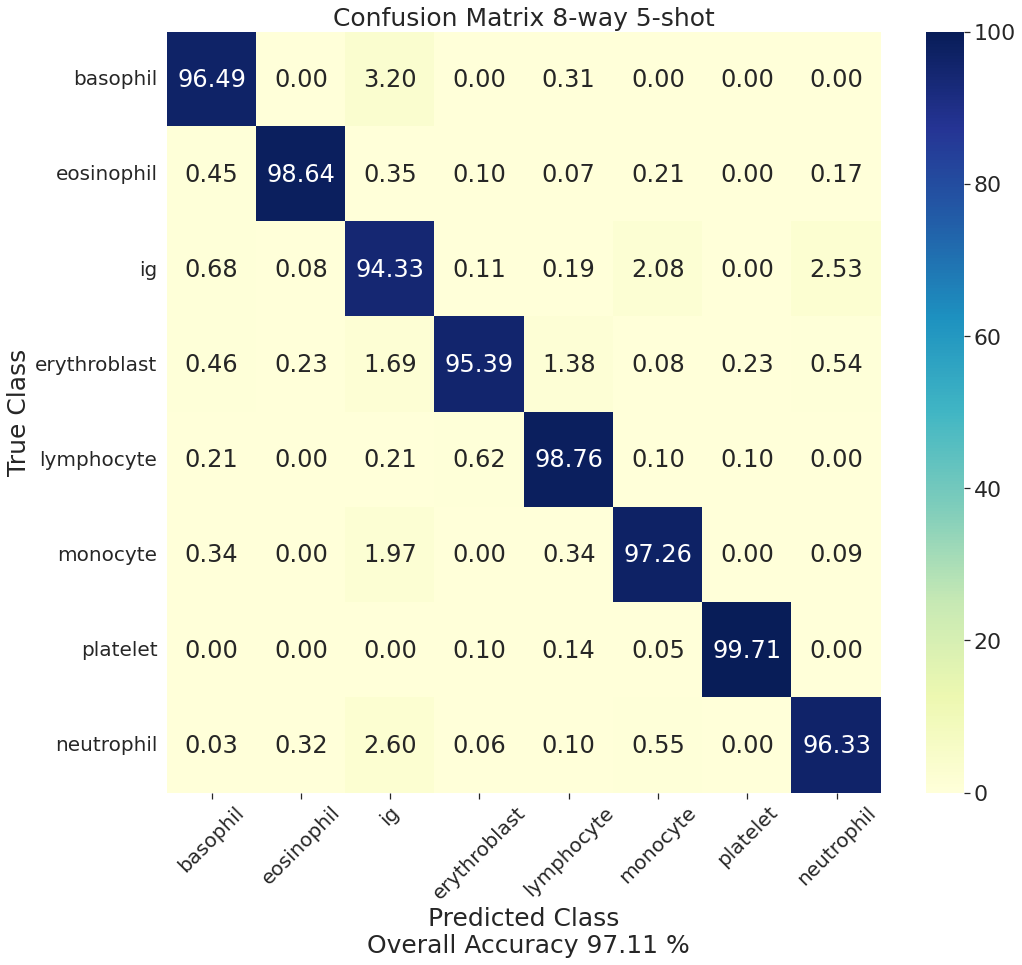

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

confusion_mat = confusion_matrix(true_cell_labels, predicted_cell_labels, normalize = 'true')
class_names = cell_types
#print(confusion_mat)

# Plotting multilabel confusion matrix in a beautiful manner
sns.set(font_scale=2)
fig = plt.figure(figsize=(16, 14))
ax= plt.subplot()
sns.heatmap(confusion_mat*100, annot=True, vmin = 0, vmax = 100, ax = ax, cmap = 'YlGnBu', fmt = '2.2f'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted Class\n Overall Accuracy 97.11 %', fontsize=25)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=45)
ax.xaxis.set_ticklabels(class_names, fontsize = 20)
ax.xaxis.tick_bottom()

ax.set_ylabel('True Class', fontsize=25)
ax.yaxis.set_ticklabels(class_names, fontsize = 20)
plt.yticks(rotation=0)

plt.title('Confusion Matrix 8-way 5-shot', fontsize=25)

plt.show()